In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('customer_data.csv')

In [3]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


In [5]:
df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000
mean,32187.500000,41.970982,31.994827,15.080234,5.400690,17.133952,541.023379,15.498850,0.473685
std,18583.317451,13.924911,17.098234,8.816470,3.114005,8.852211,260.874809,8.638436,0.499311
min,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,16094.250000,30.000000,18.000000,7.000000,3.000000,10.000000,313.000000,8.000000,0.000000
50%,32187.500000,42.000000,33.000000,15.000000,6.000000,19.000000,534.000000,15.000000,0.000000
75%,48280.750000,54.000000,47.000000,23.000000,8.000000,25.000000,768.000000,23.000000,1.000000
max,64374.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [6]:
df.drop(columns=['CustomerID'], inplace=True)

In [7]:
x = df.drop(columns=['Churn'])
y = df['Churn']

In [8]:
categorical_features = x.select_dtypes(include=['object']).columns
numerical_features = x.select_dtypes(include=['int64', 'float64']).columns

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [10]:
x_scaled = preprocessor.fit_transform(x)

applying kmeans:-
- find optimal value of k by elbow method
- implement kmeans to find the segments

In [14]:
wcss = []
silhouette_scores = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(x_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(x_scaled, labels))
    

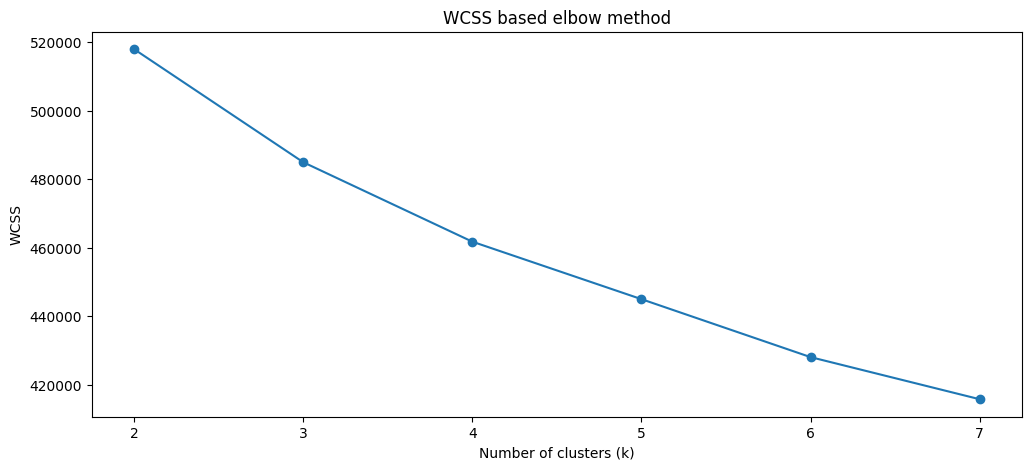

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(k_range, wcss, marker='o')
plt.title("WCSS based elbow method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.show()

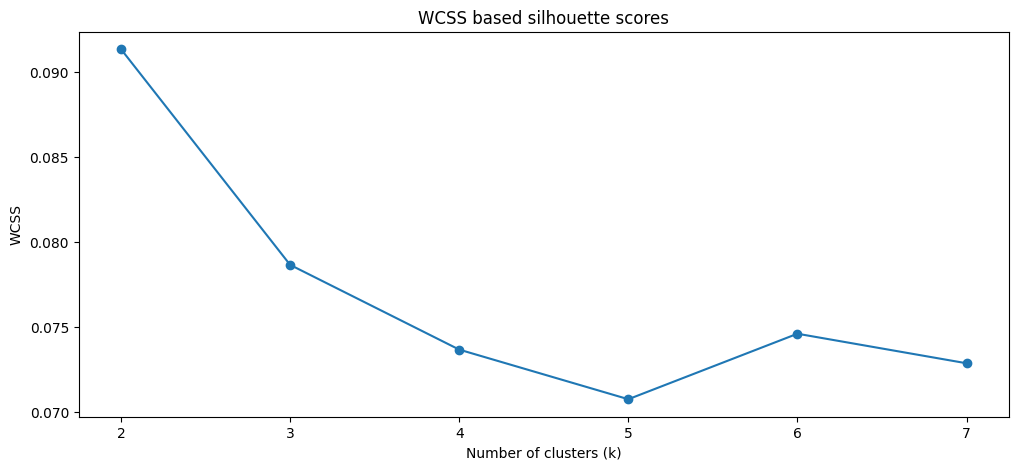

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("WCSS based silhouette scores")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.show()

k = 4 looks like the optimal value

In [18]:
kmeans = KMeans(n_clusters=4)
df['cluster'] = kmeans.fit_predict(x_scaled)

In [21]:
df['cluster'].value_counts()

cluster
2    16789
3    16674
0    16469
1    14442
Name: count, dtype: int64

<Axes: ylabel='cluster'>

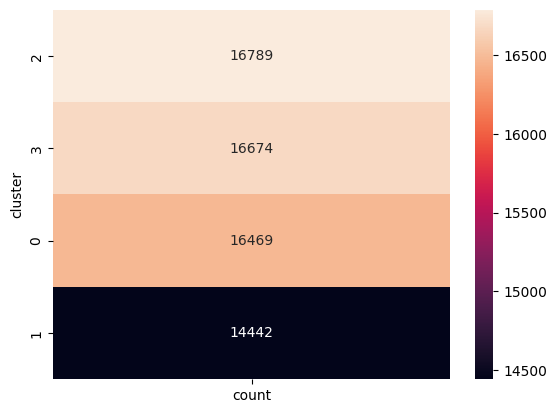

In [38]:
sns.heatmap(df['cluster'].value_counts().to_frame(), annot=True, fmt='d')

In [26]:
cluster_profile = df.groupby('cluster')[numerical_features].mean()
print("Cluster Profiles:\n", cluster_profile)

Cluster Profiles:
                Age     Tenure  Usage Frequency  Support Calls  Payment Delay  \
cluster                                                                        
0        40.161394  37.557532        23.257818       7.392131      20.887546   
1        41.295942  26.630868        15.419748       2.037668      22.550270   
2        44.115492  34.932694         6.831497       7.420752      20.143070   
3        42.183699  28.188317        15.014754       4.312582       5.705350   

         Total Spend  Last Interaction  
cluster                                 
0         553.257089         15.132188  
1         470.714582         15.575821  
2         556.631664         15.687950  
3         574.121327         15.603934  


now building the classifier

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, df['cluster'], test_size=0.2, random_state=42)

In [30]:
model = Pipeline(
    steps=[
        ('preprocessor',preprocessor),
        ('classifier', RandomForestClassifier())
    ]
)

In [31]:
model.fit(x_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
y_pred = model.predict(x_test)

In [35]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      3312
           1       0.94      0.94      0.94      2844
           2       0.95      0.95      0.95      3340
           3       0.94      0.95      0.95      3379

    accuracy                           0.95     12875
   macro avg       0.95      0.95      0.95     12875
weighted avg       0.95      0.95      0.95     12875



In [37]:
new_customer = pd.DataFrame([{
    'Age': 30,
    'Tenure': 12,
    'Usage Frequency': 10,
    'Support Calls': 2,
    'Payment Delay': 5,
    'Total Spend': 400,
    'Last Interaction': 7,
    'Gender': 'Male',
    'Subscription Type': 'Basic',
    'Contract Length': 'Month-to-month'
}])

predicted_segment = model.predict(new_customer)
print("\nNew Customer belongs to Segment:", predicted_segment[0])


New Customer belongs to Segment: 3
